# K-Nearest Neighbors (KNN) - Uber Fare Classification

## Algorithm Description

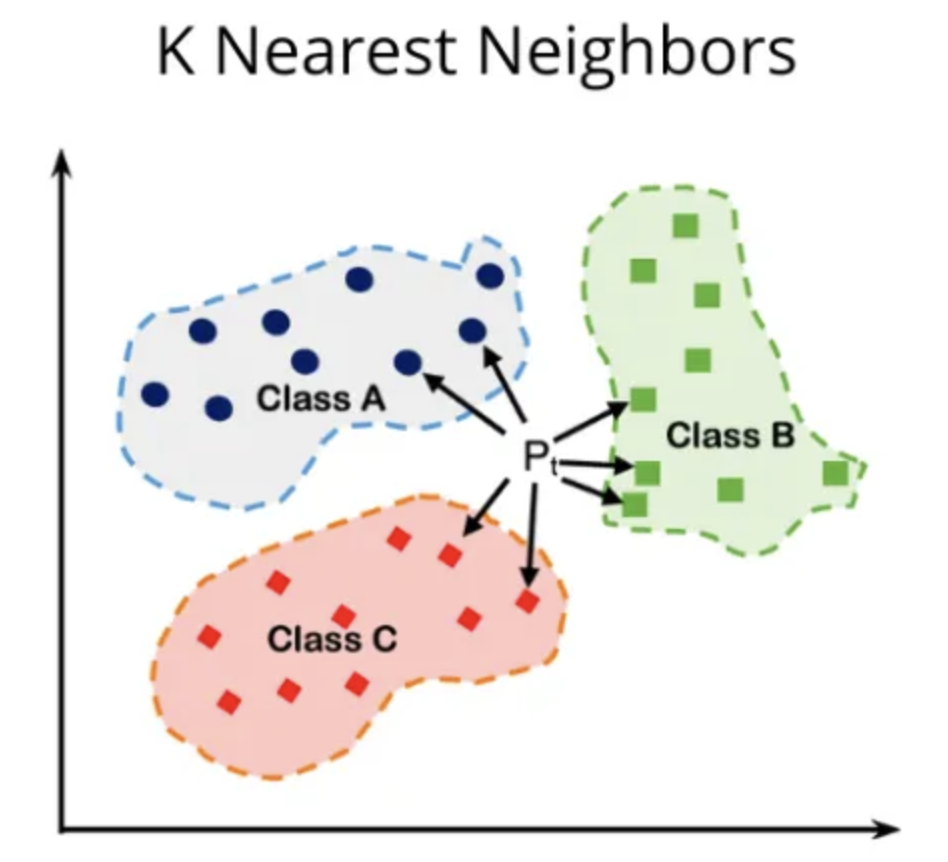

This notebook implements the **K-Nearest Neighbors (KNN)** classification algorithm using a custom-built implementation from the `rice_ml` package. The algorithm predicts whether a given Uber ride will have a **high fare (>$15)** or **low fare**, based on features such as pickup/dropoff locations, time of day, and passenger count.

The KNN algorithm classifies a test point by majority voting among its k nearest neighbors in the training set, using Euclidean distance as the similarity measure. The implementation does not rely on any built-in scikit-learn model; it is entirely constructed from scratch and accessed via:

```python
from rice_ml.knn import KNearestNeighbors
```

We also include a **balanced training version** using undersampling to address class imbalance.

### KNN Intuition

The diagram above illustrates how the K-Nearest Neighbors (KNN) algorithm classifies a new point `P`. It looks at the `k` nearest training samples—measured using distance (typically Euclidean)—and assigns `P` the majority label among those neighbors.

In this example:
- Point `P` lies near samples from three classes: **Class A (blue)**, **Class B (green)**, and **Class C (red)**.
- Based on the class labels of the nearest neighbors, the model selects the majority vote as the predicted class.

KNN is a **non-parametric**, **lazy learning** algorithm that requires no training phase. Instead, it makes predictions based on the structure of the data in feature space.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cloning into 'INDE577_ML_Rice_2025'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 282 (delta 134), reused 147 (delta 55), pack-reused 0 (from 0)
Receiving objects: 100% (282/282), 10.47 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== KNN Model Evaluation ===
Test Accuracy: 0.8320
Precision:     0.7083
Recall:        0.0955


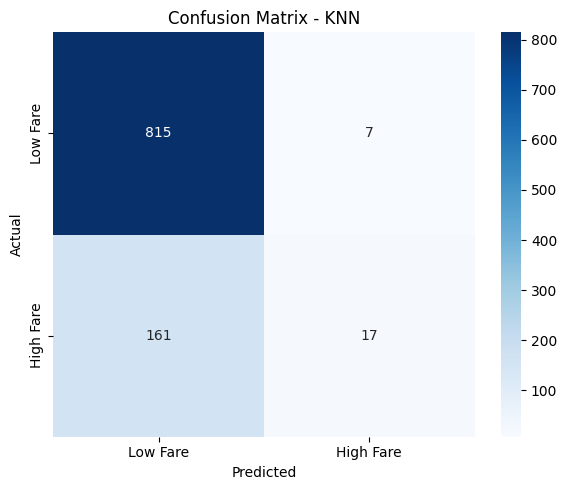

In [3]:
# Step 1: Clone GitHub repo and import your custom KNN model
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

import sys
sys.path.append('/content/INDE577_ML_Rice_2025')

from rice_ml.knn import KNearestNeighbors
from rice_ml.metrics import accuracy

# Step 2: Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Step 3: Load and clean data
csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"
df = pd.read_csv(csv_path)
df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()
df = df[df['fare_amount'] < 100]
df['label'] = (df['fare_amount'] > 15).astype(int)
df = df.sample(n=5000, random_state=42)

# Step 4: Feature engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['hour_exact_x_passenger'] = df['hour_exact'] * df['passenger_count']
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

features = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'hour_exact', 'dayofweek', 'is_weekend',
    'hour_exact_x_passenger', 'manhattan_distance'
]
X_raw = df[features].values
y = df['label'].values

# Step 5: Standardize and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Train and evaluate KNN model
model = KNearestNeighbors(k=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)

print("=== KNN Model Evaluation ===")
print(f"Test Accuracy: {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")

# Step 7: Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Fare", "High Fare"], yticklabels=["Low Fare", "High Fare"])
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


=== KNN Model (Balanced Training Set) ===
Test Accuracy: 0.6470
Precision:     0.2507
Recall:        0.4944


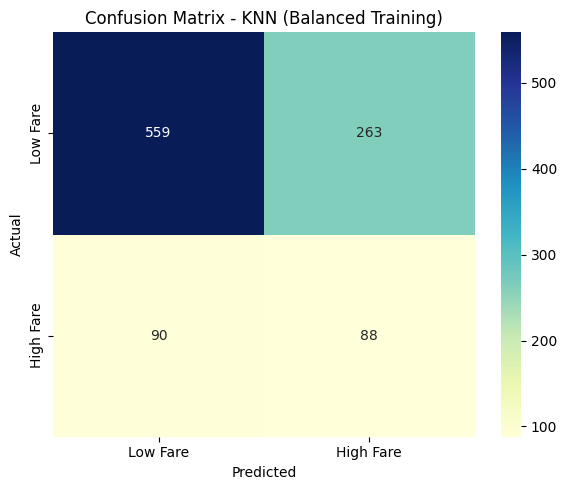

In [4]:
# Step 8: Undersample training set to balance classes
X_0 = X_train[y_train == 0]
y_0 = y_train[y_train == 0]
X_1 = X_train[y_train == 1]
y_1 = y_train[y_train == 1]

# Undersample the majority class (low fare) to match the number of high fare samples
from sklearn.utils import resample
X_0_down, y_0_down = resample(X_0, y_0,
                               replace=False,
                               n_samples=len(y_1),
                               random_state=42)

# Combine balanced data
X_bal = np.vstack((X_0_down, X_1))
y_bal = np.hstack((y_0_down, y_1))

# Step 9: Train KNN on balanced data
model_bal = KNearestNeighbors(k=5)
model_bal.fit(X_bal, y_bal)
y_pred_bal = model_bal.predict(X_test)

# Step 10: Evaluate balanced model
acc_bal = accuracy(y_test, y_pred_bal)
precision_bal = precision_score(y_test, y_pred_bal, zero_division=0)
recall_bal = recall_score(y_test, y_pred_bal, zero_division=0)

print("=== KNN Model (Balanced Training Set) ===")
print(f"Test Accuracy: {acc_bal:.4f}")
print(f"Precision:     {precision_bal:.4f}")
print(f"Recall:        {recall_bal:.4f}")

# Step 11: Visualize confusion matrix
cm_bal = confusion_matrix(y_test, y_pred_bal)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Low Fare", "High Fare"],
            yticklabels=["Low Fare", "High Fare"])
plt.title("Confusion Matrix - KNN (Balanced Training)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


###Comparison: KNN on Raw vs. Balanced Training Data

The comparison reveals a classic trade-off between overall accuracy and the ability to detect minority class cases. The **original KNN model trained on raw data** achieved a high accuracy of **83.2%**, but performed poorly in identifying high-fare rides, with a recall of only **9.6%**. It predicted almost all rides as low fare, missing most of the actual high-fare cases.

After **balancing the training data using undersampling**, the model’s **recall increased significantly to 49.4%**, capturing nearly half of the high-fare rides. However, this improvement came at the cost of a **lower overall accuracy of 64.7%**, and a **precision drop to 25.1%**, indicating more false positives for high-fare predictions.

In summary, while the raw model is biased toward the majority class (low fare), the balanced model sacrifices accuracy to better detect rare but important events—making it more suitable in contexts where **recall of the minority class matters more than overall correctness**.